In [2]:
import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_landing_data as pro_rd
import assessments.scores as es_as
import pickle
import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
import vicon_imu_data_process.augmentation_data as aug

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

#from estimation_study import *
#from estimation_assessment.visualization import *
#import pdb
import re
import logging
logging.basicConfig(level=logging.ERROR)

## Analysis the all subjects landing data with and with normalization

In [2]:
# load all subjects and trials with all features
all_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name= os.path.join(DATA_PATH,'all_subjects_landing_data_with_allfeatures.hdf5'))
print(all_subjects_trials_dataset.keys())
print('Subjects trials:',pro_rd.get_subjects_trials(all_subjects_trials_dataset))

dict_keys(['P_08_zhangboyuan', 'P_09_libang', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_12_fuzijun', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])
Subjects trials: {'P_08_zhangboyuan': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40'], 'P_09_libang': ['01', '02', '03', '04', '05', '06', '07', '08', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40'], 'P_10_dongxuan': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '

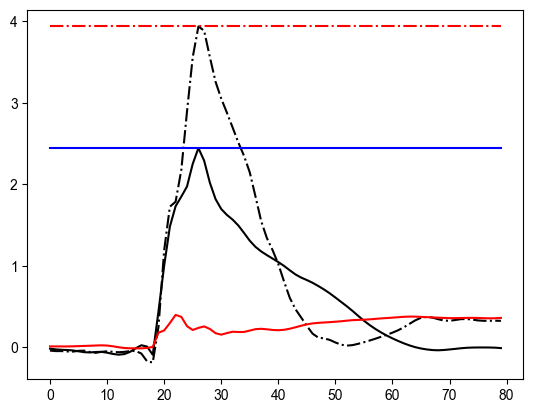

In [5]:
# plot data
plt.plot(all_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_X'],'k-.')
plt.plot(all_subjects_trials_dataset['P_08_zhangboyuan']['05']['PEAK_R_KNEE_MOMENT_X'],'r-.')
plt.plot(all_subjects_trials_dataset['P_14_hunan']['05']['R_KNEE_MOMENT_X'],'k')
plt.plot(all_subjects_trials_dataset['P_14_hunan']['05']['R_KNEE_MOMENT_Y'],'r')
plt.plot(all_subjects_trials_dataset['P_14_hunan']['05']['PEAK_R_KNEE_MOMENT_X'],'b')
#plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_SHANK_Accel_X'][0:],'r')
#plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_SHANK_Accel_Y'][0:],'g')
#plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_SHANK_Accel_Z'][0:],'b')

In [13]:
# load selected and norm landing data and its scaler
selected_norm_dataset, _ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'selection/tre_double_leg_norm_landing_data.hdf5'))
print(selected_norm_dataset.keys())
scaler_file = os.path.join(DATA_PATH,'selection/double_leg_landing_scaler_file.pkl')
scaler  = pickle.load(open(scaler_file,'rb'))


dict_keys(['P_08_zhangboyuan', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])


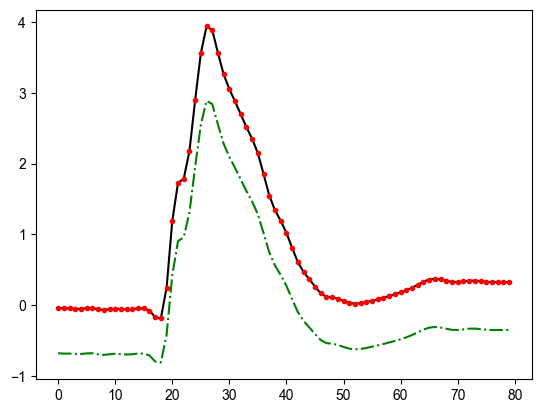

In [15]:
# plot all subject data, selected_norm data, and inverse selected_norm data
a_subject_name_id = 'P_08_zhangboyuan'
a_trial_id = '05'
field = 'R_KNEE_MOMENT_X'

plt.plot(all_subjects_trials_dataset[a_subject_name_id][a_trial_id][field],'k-')
plt.plot(selected_norm_dataset[a_subject_name_id][a_trial_id][field],'g-.')

inverse_a_trial_data=scaler.inverse_transform(selected_norm_dataset[a_subject_name_id][a_trial_id])
pd_inverse_a_trial_data = pd.DataFrame(inverse_a_trial_data,columns=selected_norm_dataset[a_subject_name_id][a_trial_id].columns)
plt.plot(pd_inverse_a_trial_data[field],'r.')



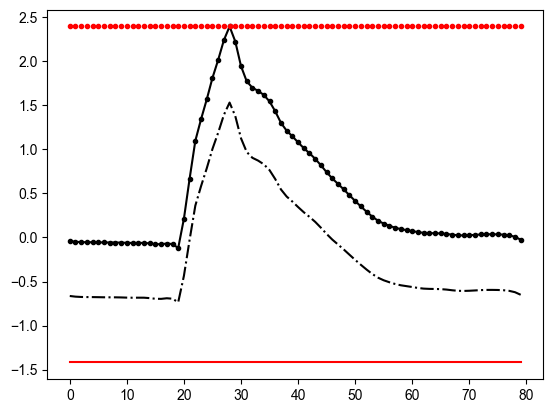

In [18]:
pall_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'all_subjects_landing_data_withpeak.hdf5'))
kem_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'selection','selection_15sub_25tri_kem_norm_landing_data.hdf5'))
pkem_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'selection','selection_15sub_25tri_pkem_norm_landing_data.hdf5'))

plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k')
plt.plot(pall_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k.')
plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k-.')
plt.plot(pkem_subjects_trials_dataset['P_14_hunan']['03']['PEAK_R_KNEE_MOMENT_X'],'r')
plt.plot(pall_subjects_trials_dataset['P_14_hunan']['03']['PEAK_R_KNEE_MOMENT_X'],'r.')
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_X'])
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_Y'])
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_Z'])


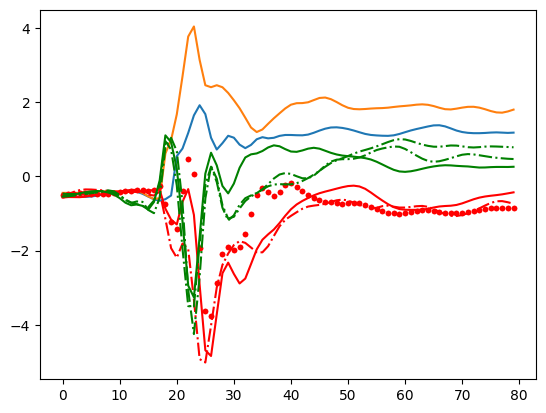

In [41]:
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k')
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_Y'])
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['04']['R_KNEE_MOMENT_Y'])
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['03']['R_KNEE_MOMENT_Y'],'r')
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['04']['R_KNEE_MOMENT_Y'],'r-.')
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_Y'],'r.')
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_Y'],'r.')
plt.plot(kam_subjects_trials_dataset['P_11_liuchunyu']['05']['R_KNEE_MOMENT_Y'],'g-')
plt.plot(kam_subjects_trials_dataset['P_11_liuchunyu']['02']['R_KNEE_MOMENT_Y'],'g-.')
plt.plot(kam_subjects_trials_dataset['P_11_liuchunyu']['01']['R_KNEE_MOMENT_Y'],'g-.')


In [134]:
# augmentation dataset

aug0_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_6rotid_15sub_25tri_kem_norm_landing_data.hdf5'))
aug1_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_7rotid_15sub_25tri_kem_norm_landing_data.hdf5'))
aug2_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_8rotid_15sub_25tri_kem_norm_landing_data.hdf5'))
aug3_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_9rotid_15sub_25tri_kem_norm_landing_data.hdf5'))

dict_keys(['01_0', '01_1', '01_2', '01_3', '01_4', '01_5', '01_6', '01_7', '01_8', '02_0', '02_1', '02_2', '02_3', '02_4', '02_5', '02_6', '02_7', '02_8', '03_0', '03_1', '03_2', '03_3', '03_4', '03_5', '03_6', '03_7', '03_8', '04_0', '04_1', '04_2', '04_3', '04_4', '04_5', '04_6', '04_7', '04_8', '05_0', '05_1', '05_2', '05_3', '05_4', '05_5', '05_6', '05_7', '05_8', '06_0', '06_1', '06_2', '06_3', '06_4', '06_5', '06_6', '06_7', '06_8', '07_0', '07_1', '07_2', '07_3', '07_4', '07_5', '07_6', '07_7', '07_8', '08_0', '08_1', '08_2', '08_3', '08_4', '08_5', '08_6', '08_7', '08_8', '09_0', '09_1', '09_2', '09_3', '09_4', '09_5', '09_6', '09_7', '09_8', '10_0', '10_1', '10_2', '10_3', '10_4', '10_5', '10_6', '10_7', '10_8', '11_0', '11_1', '11_2', '11_3', '11_4', '11_5', '11_6', '11_7', '11_8', '12_0', '12_1', '12_2', '12_3', '12_4', '12_5', '12_6', '12_7', '12_8', '13_0', '13_1', '13_2', '13_3', '13_4', '13_5', '13_6', '13_7', '13_8', '14_0', '14_1', '14_2', '14_3', '14_4', '14_5', '14_6

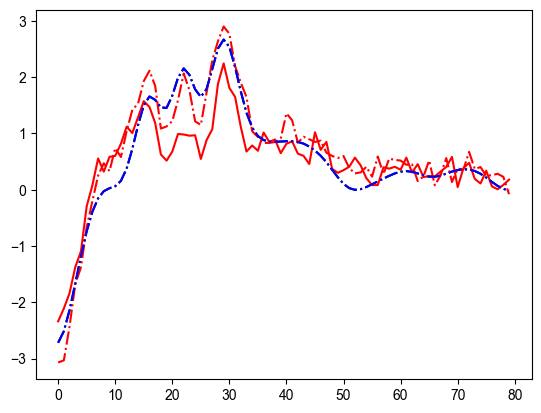

In [136]:
plt.plot(kem_subjects_trials_dataset['P_11_liuchunyu']['01']['CHEST_Accel_X'],'k-.')
plt.plot(aug0_kem_subjects_trials_dataset['P_11_liuchunyu']['01_0']['CHEST_Accel_X'],'r-.')
plt.plot(aug1_kem_subjects_trials_dataset['P_11_liuchunyu']['01_0']['CHEST_Accel_X'],'r-')
plt.plot(aug3_kem_subjects_trials_dataset['P_11_liuchunyu']['01']['CHEST_Accel_X'],'b-.')
#plt.plot(aug2_kem_subjects_trials_dataset['P_11_liuchunyu']['01 ']['CHEST_Accel_X'],'b-')
aug2_kem_subjects_trials_dataset['P_11_liuchunyu'].keys()

# Validate the peak values (peak knee moment)

In [19]:
all_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'selection','double_leg_norm_landing_data.hdf5'))
all_subjects_trials_dataset.keys()

###add_features(all_subjects_trials_dataset, save_file_name="features_all_subjects_landing_data.hdf5")

dict_keys(['P_08_zhangboyuan', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])

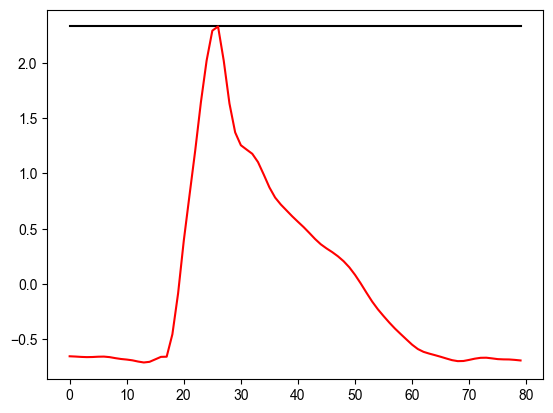

In [42]:

plt.plot(ss['P_14_hunan']['04']['PEAK_R_KNEE_MOMENT_X'],'k')
plt.plot(ss['P_14_hunan']['04']['R_KNEE_MOMENT_X'],'r')
#plt.plot(ss['P_14_hunan']['04']['PEAK_R_GRF_X'],'k-.')
#plt.plot(ss['P_14_hunan']['04']['R_GRF_X'],'r.-')

# IMU data augmentation code
## Tao

In [3]:
# load landing_data

all_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'all_subjects_landing_data_with_allfeatures.hdf5'))
all_subjects_trials_dataset.keys()


#norm_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(data_file_name = os.path.join(DATA_PATH,'original',"a5_rdouble_leg_norm_landing_data.hdf5"))
#norm_subjects_trials_dataset.keys()

def get_a_sensor_data(subjects_trials_data=all_subjects_trials_dataset, subject_id_name='P_08_zhangboyuan', trial_id='01', sensor_pos='CHEST', field='Accel'):
    return subjects_trials_data[subject_id_name][trial_id][[sensor_pos+"_"+field+ff for ff in ['_X','_Y','_Z']]].values



subject_id_name='P_08_zhangboyuan'
trial_id='02'
aug_trial_idx=  ['0','1','2','3','4','5']
sensor_pos='CHEST'
field='Accel'
data = get_a_sensor_data(subjects_trials_data=all_subjects_trials_dataset, subject_id_name=subject_id_name, trial_id=trial_id, sensor_pos=sensor_pos, field=field)


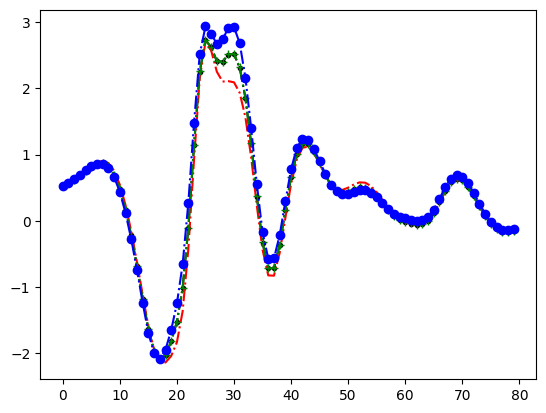

In [22]:
import numpy as np
from scipy import signal




# Example usage
imu_data = data #np.sin(np.random.rand(20, 6))  # Example IMU data array
flipped_data = aug.flip_data(imu_data)
rotated_data = aug.rotate_data(imu_data, 2)
da_rotated_data = aug.DA_Rotation(imu_data, 2)
e_rotated_data = aug.elaborate_rotate_data(imu_data, 2)
#noisy_data = aug.add_noise(imu_data, 0.02)
noisy_data = aug.DA_Jitter(imu_data, 0.05)
shifted_data = aug.shift_data(imu_data, 5)
scaled_data = aug.DA_Scaling(imu_data, 0.2)
e_scaled_data = aug.elaborate_scale_data(imu_data, 0.15)
#scaled_data = aug.scale_magnitude(imu_data, 1.05)
permutation_data = aug.DA_Permutation(imu_data)


plt.plot(imu_data[:,0],'k-.',marker='.')
plt.plot(rotated_data[:,0],'r-.')
plt.plot(da_rotated_data[:,0],'g-.+')
plt.plot(e_rotated_data[:,0],'b-.o')
#plt.plot(flipped_data[:,0],'g-.')
#plt.plot(noisy_data[:,0],'b-.o')
#plt.plot(shifted_data[:,0],'y-.')
#plt.plot(scaled_data[:,0],'m-*')
#plt.plot(e_scaled_data[:,0],'m-+')
# plt.plot(permutation_data[:,0],'c-^')

## Terryum

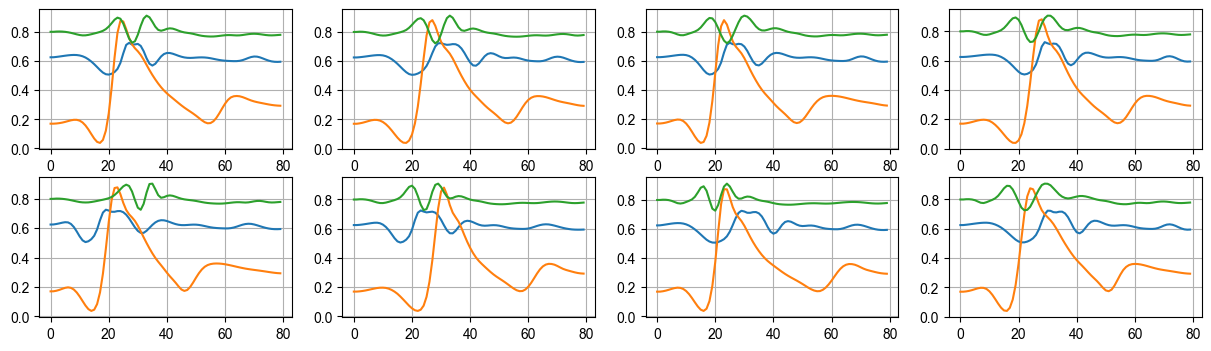

In [9]:
#data=all_subjects_trials_dataset[subject_id_name][trial_id][['CHEST_Accel_X','CHEST_Accel_Y','CHEST_Accel_Z','CHEST_Gyro_Y']].values
fig = plt.figure(figsize=(15,4))
sigma =.2
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(aug.DA_TimeWarp(data, sigma))
    #ax.set_xlim([0,3600])
    #ax.set_ylim([0,1])
    ax.grid()

# Load measured/original data and augmented datas

In [40]:
# load the selected subjects data
subject_num=15; trial_num=25
dataset_name='original'
prefix_name = "tre_a4_rdouble_leg_"
base_name = "norm_landing_data.hdf5"
data_file_name = os.path.join(DATA_PATH,dataset_name,prefix_name+base_name)
print(data_file_name)
measured_subjects_trials_data, _= pro_rd.load_subjects_dataset(data_file_name=data_file_name)
print(measured_subjects_trials_data.keys())

# load the augmented subjects data
dataset_name='timewarp'
prefix_name = "tre_tw1_rdouble_leg_"
data_file_name = os.path.join(DATA_PATH,dataset_name,prefix_name+base_name)
print(data_file_name)
augmented_subjects_trials_data, _ = pro_rd.load_subjects_dataset(data_file_name=data_file_name)
print(augmented_subjects_trials_data.keys())


a_subject = 'P_10_dongxuan'
print('measured subject trials of a subject:',measured_subjects_trials_data[a_subject].keys())
print('augment subject trials of a subject:',augmented_subjects_trials_data[a_subject].keys())


/media/sun/TFcard/drop_landing_workspace/data/original/tre_a4_rdouble_leg_norm_landing_data.hdf5
dict_keys(['P_08_zhangboyuan', 'P_09_libang', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_12_fuzijun', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])
/media/sun/TFcard/drop_landing_workspace/data/timewarp/tre_tw1_rdouble_leg_norm_landing_data.hdf5
dict_keys(['P_08_zhangboyuan', 'P_09_libang', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_12_fuzijun', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])
measured subject trials of a subject: dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 

### Compare curves of the measured and augmentation data

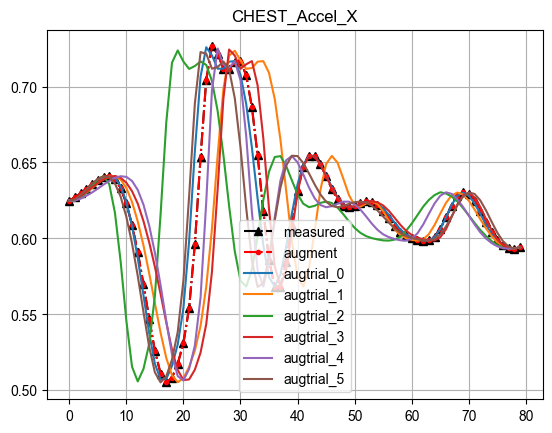

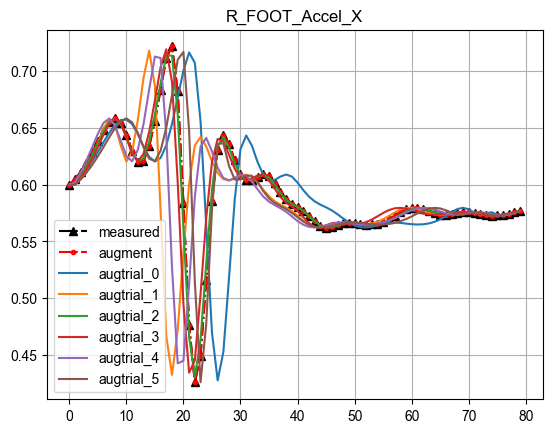

In [41]:
def complot(mdata,adata,subject_id_name='P_08_zhangboyuan',trial_id='01', aug_trial_idx=['1','2','3'],field='CHEST_Accel_Y'):
    plt.figure()
    plt.plot(mdata[subject_id_name][trial_id][field],'k-.',marker='^')
    plt.plot(adata[subject_id_name][trial_id][field],'r-.',marker='.')
    for idx in aug_trial_idx:
        plt.plot(adata[subject_id_name][trial_id+'_'+idx][field])
    plt.legend(['measured','augment']+['augtrial_'+idx for idx in aug_trial_idx])
    plt.grid()
    plt.title(field)
        
subject_id_name='P_08_zhangboyuan'
trial_id='02'
aug_trial_idx=  ['0','1','2','3','4','5']
field='CHEST_Accel_X'
complot(measured_subjects_trials_data,augmented_subjects_trials_data,subject_id_name,trial_id,aug_trial_idx,field=field)
field='R_FOOT_Accel_X'
complot(measured_subjects_trials_data,augmented_subjects_trials_data,subject_id_name,trial_id,aug_trial_idx,field=field)

### Compare magnitude of the measrued and augmentation data (only rotation transform without noise, shift, and sclaer ) 

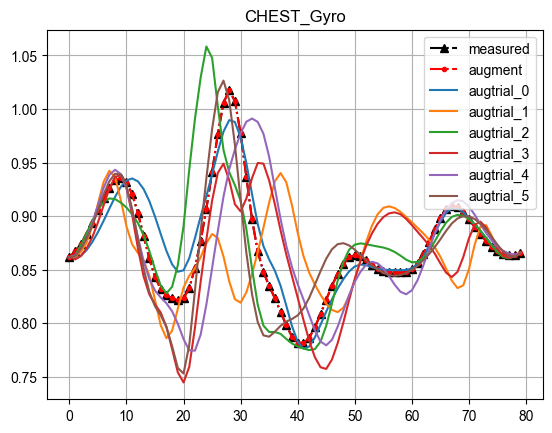

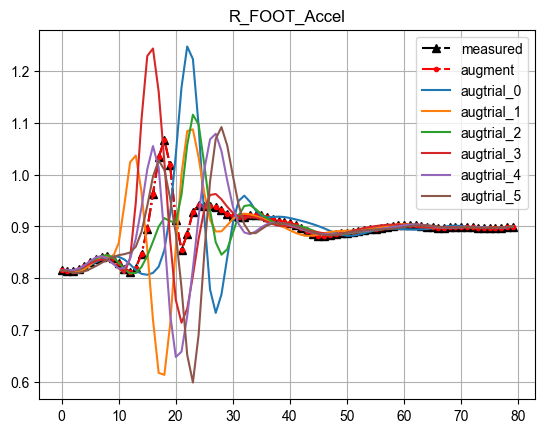

In [42]:
def calculate_magnitude(data, field='CHEST_Accel'):
    assert(isinstance(data, pd.DataFrame))
    a_x = data[field+'_X']
    a_y = data[field+'_Y']
    a_z = data[field+'_Z']
    a_a = np.sqrt(a_x**2 + a_y**2 + a_z**2)
    return a_a


def mag_complot(mdata,adata,subject_id_name='P_08_zhangboyuan',trial_id='01', aug_trial_idx=['1','2','3'],field='CHEST_Accel'):
    plt.figure()
    plt.plot(calculate_magnitude(mdata[subject_id_name][trial_id],field),'k-.',marker='^')
    plt.plot(calculate_magnitude(adata[subject_id_name][trial_id],field),'r-.',marker='.')
    for idx in aug_trial_idx:
        plt.plot(calculate_magnitude(adata[subject_id_name][trial_id+'_'+idx],field))
        
    plt.legend(['measured','augment'] + ['augtrial_' + idx for idx in aug_trial_idx])
    plt.grid()
    plt.title(field)
        
        

        
        
aug_trial_idx=  ['0','1','2','3','4','5']
field='CHEST_Gyro'
mag_complot(measured_subjects_trials_data,augmented_subjects_trials_data,subject_id_name,trial_id,aug_trial_idx,field=field)
field='R_FOOT_Accel'
mag_complot(measured_subjects_trials_data,augmented_subjects_trials_data,subject_id_name,trial_id,aug_trial_idx,field=field)


### Checking data loader

In [13]:
import sys
import os
sys.path.append("./../DeepDA")
from main import *


"""Get default arguments."""
parser = configargparse.ArgumentParser()
parser.add_argument('--labels_name',type=str,nargs='+')      # option that takes a value

args = parser.parse_args(args=[])


base_name = "norm_landing_data.hdf5"
prefix_name = "double_leg_"
tst = os.path.join("selection",prefix_name+base_name)
print(tst)
setattr(args, "tst_domain",tst)


# load the augmented subjects data
tre = os.path.join("augmentation",prefix_name+base_name)
print(tre)
setattr(args, "tre_domain",tre)
parser.set_defaults(data_dir=const.DATA_PATH)


#data path
args.data_dir = const.DATA_PATH

# features
features_name = const.extract_imu_fields(const.IMU_SENSOR_LIST, const.ACC_GYRO_FIELDS)
setattr(args, "features_name", features_name)
setattr(args, "n_labels", 1)
setattr(args, "labels_name", ["R_KNEE_MOMENT_X"])
setattr(args,'src_domain','None')
setattr(args,'tcl_domain','None')
setattr(args,'batch_size',1)
setattr(args,'num_workers',1)

#
# load multiple domain datasets
multiple_domain_datasets, _ = open_datafile(args)

selection/double_leg_norm_landing_data.hdf5
augmentation/double_leg_norm_landing_data.hdf5


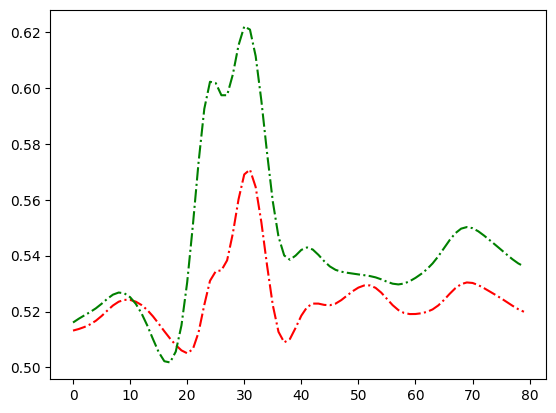

In [21]:
mdata1_1 = multiple_domain_datasets['tst'][subject_id_name][trial_id]
nonrot_trial_idx= 1
adata1_1 = multiple_domain_datasets['tre'][subject_id_name][trial_id+'_'+str(nonrot_trial_idx)]

plt.plot(mdata1_1['CHEST_Accel_X'],'r-.')
plt.plot(adata1_1['CHEST_Accel_X'],'g-.')

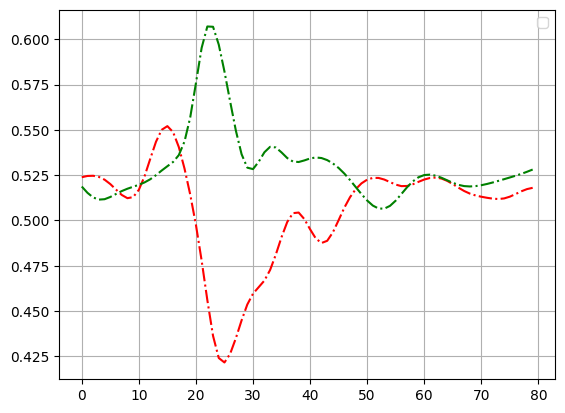

In [24]:
domain_data_loaders, n_labels = load_data(args, multiple_domain_datasets)


x1 = next(iter(domain_data_loaders['tre']))
y1 = next(iter(domain_data_loaders['tst']))


x11 = x1[0].squeeze().reshape(80,-1)
y11 = y1[0].squeeze().reshape(80,-1)

x111=x11.numpy()
y111=y11.numpy()


#plt.plot(mdata['CHEST_Accel_X'],'k')
#plt.plot(mdata1_1['CHEST_Accel_X'],'r-.')
#plt.plot(adata1_1['CHEST_Accel_X'],'g')
plt.plot(x111[:,features_name.index('CHEST_Accel_X')],'r-.')
plt.plot(y111[:,features_name.index('CHEST_Accel_X')],'g-.')
plt.legend()
plt.grid()

# View data from an  image aspect

In [25]:
subjects_trials_dataset, _= pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selection','double_leg_norm_landing_data.hdf5'))

['CHEST_Accel_X', 'CHEST_Accel_Y', 'CHEST_Accel_Z', 'CHEST_Gyro_X', 'CHEST_Gyro_Y', 'CHEST_Gyro_Z', 'CHEST_Mag_X', 'CHEST_Mag_Y', 'CHEST_Mag_Z', 'WAIST_Accel_X', 'WAIST_Accel_Y', 'WAIST_Accel_Z', 'WAIST_Gyro_X', 'WAIST_Gyro_Y', 'WAIST_Gyro_Z', 'WAIST_Mag_X', 'WAIST_Mag_Y', 'WAIST_Mag_Z', 'R_THIGH_Accel_X', 'R_THIGH_Accel_Y', 'R_THIGH_Accel_Z', 'R_THIGH_Gyro_X', 'R_THIGH_Gyro_Y', 'R_THIGH_Gyro_Z', 'R_THIGH_Mag_X', 'R_THIGH_Mag_Y', 'R_THIGH_Mag_Z', 'R_SHANK_Accel_X', 'R_SHANK_Accel_Y', 'R_SHANK_Accel_Z', 'R_SHANK_Gyro_X', 'R_SHANK_Gyro_Y', 'R_SHANK_Gyro_Z', 'R_SHANK_Mag_X', 'R_SHANK_Mag_Y', 'R_SHANK_Mag_Z', 'R_FOOT_Accel_X', 'R_FOOT_Accel_Y', 'R_FOOT_Accel_Z', 'R_FOOT_Gyro_X', 'R_FOOT_Gyro_Y', 'R_FOOT_Gyro_Z', 'R_FOOT_Mag_X', 'R_FOOT_Mag_Y', 'R_FOOT_Mag_Z', 'L_THIGH_Accel_X', 'L_THIGH_Accel_Y', 'L_THIGH_Accel_Z', 'L_THIGH_Gyro_X', 'L_THIGH_Gyro_Y', 'L_THIGH_Gyro_Z', 'L_THIGH_Mag_X', 'L_THIGH_Mag_Y', 'L_THIGH_Mag_Z', 'L_SHANK_Accel_X', 'L_SHANK_Accel_Y', 'L_SHANK_Accel_Z', 'L_SHANK_Gyro_X

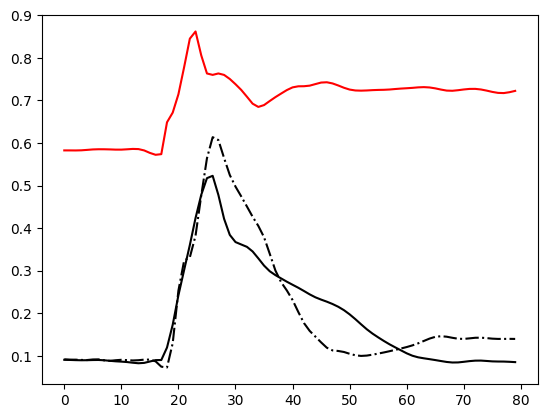

In [26]:
plt.plot(subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_X'],'k-.')
plt.plot(subjects_trials_dataset['P_14_hunan']['04']['R_KNEE_MOMENT_X'],'k')
plt.plot(subjects_trials_dataset['P_14_hunan']['04']['R_KNEE_MOMENT_Y'],'r')
print(const.FEATURES_FIELDS)

tmp_data = subjects_trials_dataset['P_14_hunan']['04'][const.SELECTED_FEATURES_NAME].values

## Show features using image

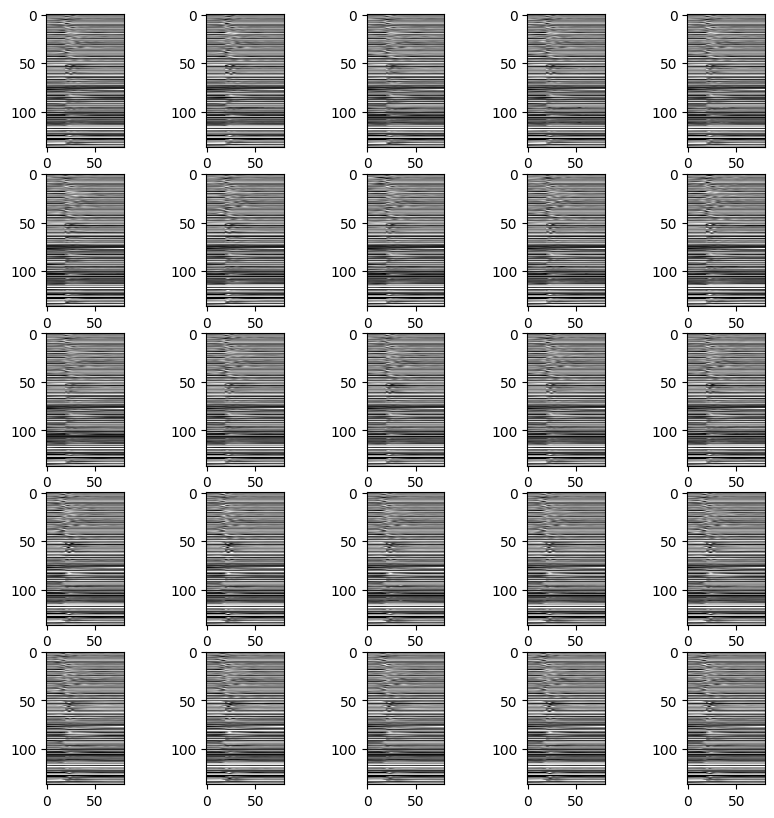

In [27]:
# 1. show featrues of measured dataset

subjects_trials = {subject_id_name: subjects_trials_dataset[subject_id_name].keys() for subject_id_name in subjects_trials_dataset.keys()} # get subjects_tials
subject_ids_names = subjects_trials.keys() # get subjects

#2) concate them into a numpy for scale
list_data = [subjects_trials_dataset[subject_id_name][trial].values for subject_id_name in subject_ids_names for trial in subjects_trials[subject_id_name]]

fig, axes = plt.subplots(5,5, figsize=(10,10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(list_data[idx].T, interpolation='nearest', cmap='gray')

/media/suntao/DATA/drop_landing_workspace/data/augmentation/double_leg_norm_landing_data.hdf5


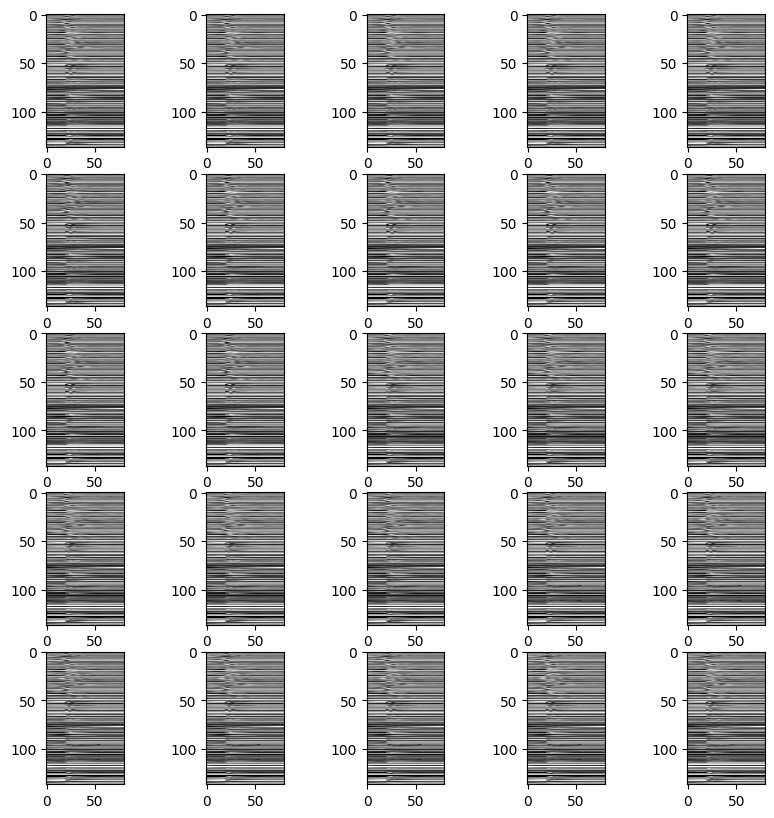

In [28]:
# 2. show featrues of augmentaed dataset

base_name = "norm_landing_data.hdf5"
prefix_name = "double_leg_"
h5_file_name = os.path.join(DATA_PATH,"augmentation",prefix_name+base_name)
print(h5_file_name)
augmented_subjects_trials_dataset, _ = pro_rd.load_subjects_dataset(h5_file_name=h5_file_name)


subjects_trials = {subject_id_name: augmented_subjects_trials_dataset[subject_id_name].keys() for subject_id_name in augmented_subjects_trials_dataset.keys()} # get subjects_tials
subject_ids_names = subjects_trials.keys() # get subjects

#2) concate them into a numpy for scale
list_data = [augmented_subjects_trials_dataset[subject_id_name][trial].values for subject_id_name in subject_ids_names for trial in subjects_trials[subject_id_name]]

fig, axes = plt.subplots(5,5, figsize=(10,10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(list_data[idx].T, interpolation='nearest', cmap='gray')

### Re-organize dataset subejcts for testing some assumption 

In [137]:
# load the selected subjects data
subject_num=15; trial_num=25
base_name = "norm_landing_data.hdf5"
prefix_name = "double_leg_"
h5_file_name = os.path.join(DATA_PATH,"selection",prefix_name+base_name)
print(h5_file_name)
measured_subjects_trials_data, _= pro_rd.load_subjects_dataset(h5_file_name=h5_file_name)

measured_subjects_trials_data.keys()

subjects= list(measured_subjects_trials_data.keys())[:1]
tmp={sub: measured_subjects_trials_data[sub] for sub in subjects}

print('tmp:',tmp.keys())
print(measured_subjects_trials_data['P_10_dongxuan'].keys())
tmp['P_10_dongxuan']={'05':[],'02':[],'03':[],'04':[]}
tmp['P_10_dongxuan']['05']=measured_subjects_trials_data['P_10_dongxuan']['05']
tmp['P_10_dongxuan']['02']=measured_subjects_trials_data['P_10_dongxuan']['02']
tmp['P_10_dongxuan']['03']=measured_subjects_trials_data['P_10_dongxuan']['03']
tmp['P_10_dongxuan']['04']=measured_subjects_trials_data['P_10_dongxuan']['04']
tmp['P_10_dongxuan']['15']=measured_subjects_trials_data['P_08_zhangboyuan']['21']
tmp['P_10_dongxuan']['16']=measured_subjects_trials_data['P_08_zhangboyuan']['22']
tmp['P_10_dongxuan']['17']=measured_subjects_trials_data['P_08_zhangboyuan']['23']
tmp['P_10_dongxuan']['18']=measured_subjects_trials_data['P_08_zhangboyuan']['24']
tmp['P_10_dongxuan']['19']=measured_subjects_trials_data['P_08_zhangboyuan']['25']

print(tmp.keys())
data_folder = os.path.join(DATA_PATH,"selection")
file_name = 'double_leg_norm_landing_data_tmp.hdf5'
data_path = os.path.join(data_folder,file_name)
pro_rd.save_subjects_dataset_to_a_h5(tmp,data_path)



print(tmp['P_08_zhangboyuan'].keys())
print(tmp['P_10_dongxuan'].keys())


/media/sun/TFcard/drop_landing_workspace/data/selection/double_leg_norm_landing_data.hdf5
tmp: dict_keys(['P_08_zhangboyuan'])
dict_keys(['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'])
dict_keys(['P_08_zhangboyuan', 'P_10_dongxuan'])
dataset was stored at: /media/sun/TFcard/drop_landing_workspace/data/selection/double_leg_norm_landing_data_tmp.hdf5
dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'])
dict_keys(['05', '02', '03', '04', '15', '16', '17', '18', '19'])
